In [1]:
# ==============================
# Importación Librerías
# ==============================

from funpymodeling.exploratory import status, freq_tbl

import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# ==============================
# Importación Data
# ==============================

ruta = r"C:\Users\USER\Desktop\Escuela de Datos Vivos\data\processed.csv"
df = pd.read_csv(ruta)

In [3]:
# ==============================
# Análisis Dataset
# ==============================

print("\n===Resumen de primer análisis del dataset===")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print(f"Hay {df.duplicated().sum()} filas duplicadas")
print(f"En las columnas hay nulos?")
print(f"{df.isna().sum()}")


===Resumen de primer análisis del dataset===
Número de filas: 130736
Número de columnas: 13
Hay 0 filas duplicadas
En las columnas hay nulos?
lat                0
lon                0
country_name       0
state_name         0
place_name         0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
currency           0
property_type      0
price              0
dtype: int64


c:\Users\USER\Desktop\Escuela de Datos Vivos\edv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Count'>

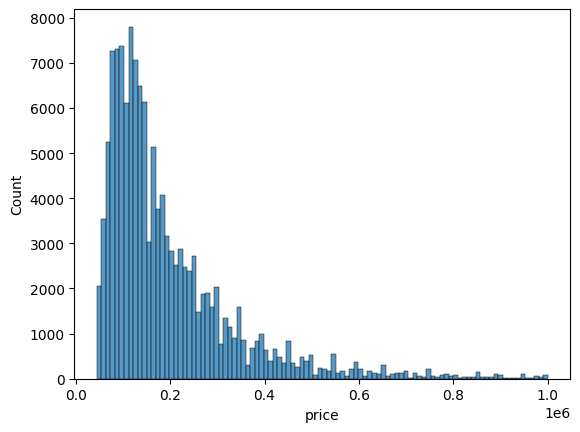

In [4]:
sns.histplot(df['price'], bins=100)

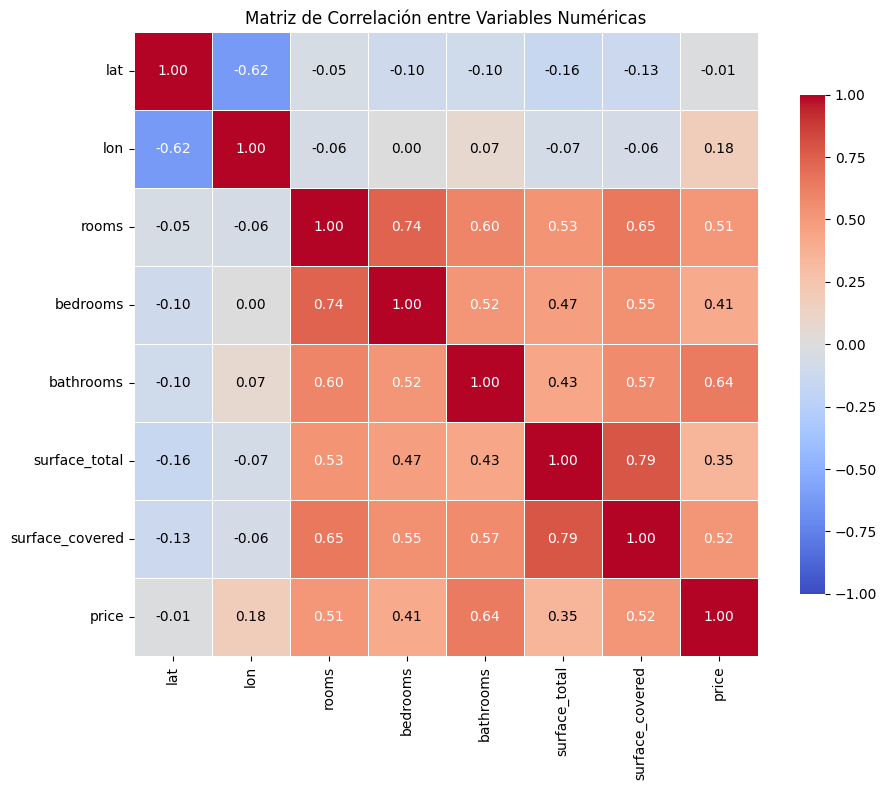

In [5]:
# Matriz de correlación

# Seleccionamos solo columnas numéricas
df_num = df.select_dtypes(include=['int64', 'float64'])

# Calculamos la matriz de correlación
corr = df_num.corr()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    annot=False,            # desactivamos para agregar textos manualmente
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

# Añadimos valores manualmente con contraste de color
umbral = 0.5
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.iloc[i, j]
        text_color = "white" if abs(val) > umbral else "black"
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}", ha='center', va='center', color=text_color, fontsize=10)

ax.set_title("Matriz de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

In [6]:
# -------------------------
#  Chequeos y limpieza
# -------------------------
print("Filas/columnas iniciales:", df.shape)

# 1.a eliminar duplicados
n_dup = df.duplicated().sum()
if n_dup > 0:
    print(f"Eliminando {n_dup} filas duplicadas.")
    df = df.drop_duplicates().reset_index(drop=True)
else:
    print("No hay duplicados.")

# 1.b chequear nulos
nulos = df.isna().sum()
print("Nulos por columna:\n", nulos[nulos>0] if (nulos>0).any() else "No hay nulos según el chequeo")

Filas/columnas iniciales: (130736, 13)
No hay duplicados.
Nulos por columna:
 No hay nulos según el chequeo


In [7]:
# Verificar duplicados exactos en todas las columnas
duplicados_totales2 = df.duplicated().sum()
print(f"Duplicados exactos (todas las columnas iguales): {duplicados_totales2}")

Duplicados exactos (todas las columnas iguales): 0


In [8]:
# Tratamos las variables categóricas

# -------------------------
#  Encoding estrategia
# -------------------------
# Decisión: One-Hot para categóricas con cardinalidad moderada.
# place_name suele ser alta cardinalidad (muchas zonas) -> uso Frequency encoding para evitar muchísimas columnas.

# =============== FREQUENCY ENCODING ==================
place_name_freq = df['place_name'].value_counts(normalize=True)
df['place_name_freq'] = df['place_name'].map(place_name_freq)


# =============== ONE-HOT ENCODING: property_type ==================
property_ohe = OneHotEncoder(sparse_output=False, drop='first')
property_encoded = property_ohe.fit_transform(df[['property_type']])

property_columns = [f"property_{cat}" for cat in property_ohe.categories_[0][1:]]

property_encoded_df = pd.DataFrame(
    property_encoded,
    columns=property_columns,
    index=df.index
)


# =============== ONE-HOT ENCODING: state_name ==================
state_ohe = OneHotEncoder(sparse_output=False, drop='first')
state_encoded = state_ohe.fit_transform(df[['state_name']])

state_columns = [f"state_{cat}" for cat in state_ohe.categories_[0][1:]]

state_encoded_df = pd.DataFrame(
    state_encoded,
    columns=state_columns,
    index=df.index
)


# =============== COMBINAR TODO ==================
df_final = pd.concat([
    df[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'place_name_freq', 'price']],
    property_encoded_df,
    state_encoded_df
], axis=1)

print("\n DATASET FINAL PARA MODELADO:")
print(f"   Dimensiones: {df_final.shape}")
print(f"   Columnas finales ({len(df_final.columns)}): {list(df_final.columns)}")


 DATASET FINAL PARA MODELADO:
   Dimensiones: (130736, 19)
   Columnas finales (19): ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'place_name_freq', 'price', 'property_Casa de campo', 'property_Cochera', 'property_Departamento', 'property_Depósito', 'property_Local comercial', 'property_Lote', 'property_Oficina', 'property_Otro', 'property_PH', 'state_Bs.As. G.B.A. Zona Oeste', 'state_Bs.As. G.B.A. Zona Sur', 'state_Capital Federal']


In [9]:
list(df_final.columns)

['rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'place_name_freq',
 'price',
 'property_Casa de campo',
 'property_Cochera',
 'property_Departamento',
 'property_Depósito',
 'property_Local comercial',
 'property_Lote',
 'property_Oficina',
 'property_Otro',
 'property_PH',
 'state_Bs.As. G.B.A. Zona Oeste',
 'state_Bs.As. G.B.A. Zona Sur',
 'state_Capital Federal']

In [10]:
# Ruta donde guardaremos los modelos
save_path = r"C:\Users\USER\Desktop\Escuela de Datos Vivos\model"
os.makedirs(save_path, exist_ok=True)

# Guardar mapeo de frecuencias
with open(os.path.join(save_path, 'place_name_freq.pkl'), 'wb') as f:
    pickle.dump(place_name_freq, f)

# Guardar OneHotEncoder de property_type
with open(os.path.join(save_path, 'property_ohe.pkl'), 'wb') as f:
    pickle.dump(property_ohe, f)

# Guardar OneHotEncoder de state_name
with open(os.path.join(save_path, 'state_ohe.pkl'), 'wb') as f:
    pickle.dump(state_ohe, f)

# Guardar columnas finales del modelo
feature_columns = list(df_final.drop('price', axis=1).columns)
with open(os.path.join(save_path, 'feature_columns.pkl'), 'wb') as f:
    pickle.dump(feature_columns, f)

print(" PREPROCESADORES GUARDADOS EN:")
print(f"   {save_path}\\place_name_freq.pkl")
print(f"   {save_path}\\property_ohe.pkl")
print(f"   {save_path}\\state_ohe.pkl")
print(f"   {save_path}\\feature_columns.pkl")

 PREPROCESADORES GUARDADOS EN:
   C:\Users\USER\Desktop\Escuela de Datos Vivos\model\place_name_freq.pkl
   C:\Users\USER\Desktop\Escuela de Datos Vivos\model\property_ohe.pkl
   C:\Users\USER\Desktop\Escuela de Datos Vivos\model\state_ohe.pkl
   C:\Users\USER\Desktop\Escuela de Datos Vivos\model\feature_columns.pkl


In [11]:
# ==============================
# MODELO DE REGRESIÓN
# ==============================

# -------------------------
#  Split Train/Test
# -------------------------

X = df_final.drop('price', axis=1)
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
# -------------------------
#  Función de evaluación
# -------------------------
def evaluar(y_true, y_pred, prefix="Modelo"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n {prefix}")
    print(f"   RMSE: ${rmse:,.0f}")
    print(f"   MAE: ${mae:,.0f}")
    print(f"   R²: {r2:.4f}")
    print(f"   Diferencia RMSE-MAE: ${rmse - mae:,.0f} (indica efecto de outliers)")
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [13]:
# -------------------------
# PRUEBAS
# -------------------------
results = {}

# ITERACIÓN: Baseline - Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

results['LinearRegression'] = evaluar(y_test, y_pred_lr, "Linear Regression Básico")



 Linear Regression Básico
   RMSE: $91,614
   MAE: $61,077
   R²: 0.5819
   Diferencia RMSE-MAE: $30,538 (indica efecto de outliers)


In [14]:
# ITERACIÓN: RandomForest Default

rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train, y_train)
y_pred_rf_default = rf_default.predict(X_test)

results['RF Default'] = evaluar(y_test, y_pred_rf_default, "RF Default")


 RF Default
   RMSE: $73,094
   MAE: $44,726
   R²: 0.7339
   Diferencia RMSE-MAE: $28,368 (indica efecto de outliers)


In [15]:
# ITERACIÓN: RF con 100 árboles

rf_100 = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_100.fit(X_train, y_train)
y_pred_rf_100 = rf_100.predict(X_test)

results['RF 100 árboles'] = evaluar(y_test, y_pred_rf_100, "RF 100 árboles")



 RF 100 árboles
   RMSE: $73,094
   MAE: $44,726
   R²: 0.7339
   Diferencia RMSE-MAE: $28,368 (indica efecto de outliers)


In [16]:
# ITERACIÓN: RF con 300 árboles

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results['RF 300 árboles'] = evaluar(y_test, y_pred_rf, "RF 300 árboles")



 RF 300 árboles
   RMSE: $72,835
   MAE: $44,589
   R²: 0.7357
   Diferencia RMSE-MAE: $28,246 (indica efecto de outliers)


In [17]:
# ITERACIÓN: RF con profundidad limitada

rf_depth = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_depth.fit(X_train, y_train)
y_pred_rf_depth = rf_depth.predict(X_test)

results['RF max_depth=10'] = evaluar(y_test, y_pred_rf_depth, "RF max_depth=10")


 RF max_depth=10
   RMSE: $77,162
   MAE: $49,222
   R²: 0.7034
   Diferencia RMSE-MAE: $27,939 (indica efecto de outliers)


In [18]:
# ITERACIÓN: RF Optimizado Manual

rf_opt = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_opt.fit(X_train, y_train)
y_pred_rf_opt = rf_opt.predict(X_test)

results['RF Optimizado'] = evaluar(y_test, y_pred_rf_opt, "RF Optimizado")


 RF Optimizado
   RMSE: $71,927
   MAE: $45,017
   R²: 0.7423
   Diferencia RMSE-MAE: $26,910 (indica efecto de outliers)


In [19]:
# ITERACIÓN: RF Robusto para mejorar efecto outliers

rf_robusto = RandomForestRegressor(
    n_estimators=300,
    max_depth=18,
    min_samples_split=8,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

rf_robusto.fit(X_train, y_train)
y_pred_rf_robusto = rf_robusto.predict(X_test)

results['RF Robusto'] = evaluar(y_test, y_pred_rf_robusto, "RF Robusto")


 RF Robusto
   RMSE: $71,888
   MAE: $44,738
   R²: 0.7426
   Diferencia RMSE-MAE: $27,149 (indica efecto de outliers)


In [20]:
# Transformamos la variable target para mejorar efecto outliers

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Entrenar el modelo
rf_log = RandomForestRegressor(
    n_estimators=400,
    max_depth=16,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

rf_log.fit(X_train, y_train_log)

# Predecir en escala log
y_pred_log = rf_log.predict(X_test)

# Volver a escala real
y_pred_real = np.expm1(y_pred_log)

# Evaluar con precios reales
results['RF log'] = evaluar(y_test, y_pred_real, "RF con Target Log")


 RF con Target Log
   RMSE: $75,924
   MAE: $46,325
   R²: 0.7128
   Diferencia RMSE-MAE: $29,600 (indica efecto de outliers)


In [21]:
# Análisis resultados

print("\n COMPARATIVA DE MODELOS:\n")
for modelo, resultado in results.items():
    print(f"{modelo}: {resultado}")


 COMPARATIVA DE MODELOS:

LinearRegression: {'RMSE': 91614.05615290393, 'MAE': 61076.55591869454, 'R2': 0.5818954194137385}
RF Default: {'RMSE': 73093.79835360097, 'MAE': 44725.85050603259, 'R2': 0.7338528844351488}
RF 100 árboles: {'RMSE': 73093.79835360097, 'MAE': 44725.85050603259, 'R2': 0.7338528844351488}
RF 300 árboles: {'RMSE': 72835.02770278939, 'MAE': 44588.630678069254, 'R2': 0.7357340057699182}
RF max_depth=10: {'RMSE': 77161.89678294188, 'MAE': 49222.41898923019, 'R2': 0.7034031789416919}
RF Optimizado: {'RMSE': 71927.06867393479, 'MAE': 45017.1656129166, 'R2': 0.742281600908602}
RF Robusto: {'RMSE': 71887.81820366139, 'MAE': 44738.46921972563, 'R2': 0.7425627970848199}
RF log: {'RMSE': 75924.37565658582, 'MAE': 46324.65533669448, 'R2': 0.7128405183024413}


Elección del Modelo

El modelo Random Forest Robusto fue seleccionado como modelo final debido a su desempeño superior en todos los indicadores clave. Comparado con las demás alternativas, presentó el menor RMSE (71888), menor MAE (44738) y el mayor R² (0.7426), lo que indica un mejor ajuste al comportamiento real de los precios y una mayor capacidad predictiva general. No se necesita transformar la variable target y además, el modelo evita el sobreajuste observado en configuraciones más restringidas y supera significativamente al modelo lineal, lo que confirma la presencia de relaciones no lineales en los datos. Por estas razones se considera el modelo más adecuado para la fase de despliegue y uso operativo.

Futuras Mejoras:

Existe efecto de outliers, es decir, el modelo es menos preciso ante precios más altos.
Las principales mejoras futuras se orientan a incorporar variables cualitativas y temporales relevantes (ej. antiguedad de la propiedad), mejorar el manejo de outliers mediante técnicas robustas, explorar modelos de ensamble más avanzados y enriquecimiento con análisis de texto. Esto permitirá aumentar la capacidad predictiva del modelo y su poder para generalizar a nuevos segmentos del mercado.

In [22]:
# ==============================
# GUARDAR MODELO EN pickle
# ==============================


save_path = r"C:\Users\USER\Desktop\Escuela de Datos Vivos\model"
with open(f"{save_path}\\rf_robusto.pkl", "wb") as f:
    pickle.dump(rf_robusto, f)

    